In [1]:
from data import *
import tensorflow as tf
from models import Eff
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

2022-06-27 10:42:49.532455: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [106]:
model = Eff('efficientnetB0')
latest=tf.train.latest_checkpoint('train_weights_combined_dataset_noisy/efficientnetB0')
model.load_weights(latest)

In [107]:
m_f=model.layers[0]
glb = model.layers[-3]
dpout = model.layers[-2]
dense = model.layers[-1]

In [108]:
x = glb(m_f.output)
x = dpout(x)
x = dense(x)

In [109]:
model_=tf.keras.Model(m_f.input,x)

In [110]:
test_data = TestGenerator().batch(16)

In [111]:
pred_classes=[]
true_classes=[]
for img,classes in test_data:
    pred_classes.append(model_(img))
    true_classes.append(classes)

In [112]:
preds=tf.concat(pred_classes,axis=0).numpy()
preds_=(preds>0.7).astype('int')

In [113]:
preds_

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 0]])

In [114]:
trues=tf.concat(true_classes,axis=0).numpy().astype('int')

In [226]:
# cm=multilabel_confusion_matrix(trues, preds_)
# print(np.array(cm))
# classes=['alines','blines','consolidation','effusion']
# fig,axes = plt.subplots(1,4,figsize=(15,3))

# a=0
# for i in range(4):
#     sns.heatmap(ax=axes[i],data=cm[a],annot=True)
#     axes[i].set_title(classes[a])
#     a+=1

# plt.show()

In [192]:
equate=preds_==trues
def find_(row):
    return row[0]&row[1]&row[2]&row[3]
returned=np.apply_along_axis(find_,1,equate)
true_pred=np.where(returned==True)
false_pred=np.where(returned==False)

In [193]:
true_pred

(array([  1,   2,   3,   4,   5,   6,   8,  10,  11,  12,  13,  15,  16,
         18,  19,  20,  21,  24,  25,  26,  27,  28,  29,  30,  31,  33,
         34,  35,  36,  37,  38,  39,  41,  42,  43,  44,  45,  48,  49,
         51,  53,  54,  55,  56,  57,  58,  59,  62,  63,  64,  65,  66,
         67,  68,  70,  71,  72,  74,  75,  76,  77,  78,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  92,  93,  94,  96,  97,  98,  99,
        100, 101, 102, 106, 107, 108, 110, 112, 113, 114, 115, 116, 117,
        120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 134,
        137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150,
        153, 154, 155, 156, 158, 159, 160, 162, 164, 167, 168, 169, 170,
        171, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186,
        187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200,
        201, 203, 204, 205, 206, 207, 210, 211, 212, 213, 214, 215, 216,
        217, 218, 219, 220, 221, 222, 223, 225, 226

In [194]:
false_pred

(array([  0,   7,   9,  14,  17,  22,  23,  32,  40,  46,  47,  50,  52,
         60,  61,  69,  73,  79,  80,  90,  91,  95, 103, 104, 105, 109,
        111, 118, 119, 126, 133, 135, 136, 146, 151, 152, 157, 161, 163,
        165, 166, 172, 173, 181, 197, 202, 208, 209, 224, 227, 228, 230,
        233, 240, 241, 246, 254, 255, 269, 276, 278, 279, 280]),)

In [117]:
test_df = pd.read_csv('inputs/cleaned_testset.csv')
test_df=test_df.drop([0,24,92,227,157,143,32,203,179,98,13,23,142,36,154,273,62,10,12,\
                      286,9,205,1,0,142,279,43,168,141,74,72,157]).reset_index()

In [196]:
true_preds=test_df.iloc[true_pred]

In [120]:
import cv2
import numpy as np

In [169]:
image =cv2.imread('dataset/denoised_data/image_7112242173346-13_15_59.png')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(224,224))

In [176]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [173]:
last_conv_layer_name='top_conv'

In [174]:
model_.layers[-1].activation = None

In [215]:
import matplotlib.cm as cm
def display_(heatmap,image):
    alpha = 0.4
    heatmap = np.uint8(255 *heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + image
    return superimposed_img/255.

In [224]:
def display_results(df):

    fig,axes=plt.subplots(10,2,figsize=(15,50))
    classes=np.array(['alines','blines','consolidation','effusion'])
    a=0
    for i in range(10):
        k=cv2.imread(df.image.values.tolist()[a])
        k=cv2.cvtColor(k,cv2.COLOR_BGR2RGB)
        k = cv2.resize(k,(224,224))
        axes[i,0].set_title(df[['alines','blines','consolidation','effusion']].values[a])
        axes[i,0].imshow(k)
        heatmap = make_gradcam_heatmap(np.expand_dims(k,0), model_, last_conv_layer_name)
        superimposed_img =display_(heatmap,k)
        axes[i,1].imshow(superimposed_img)
        a+=1

    plt.show()

/home/g007markphillip/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/g007markphillip/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/g007markphillip/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RG

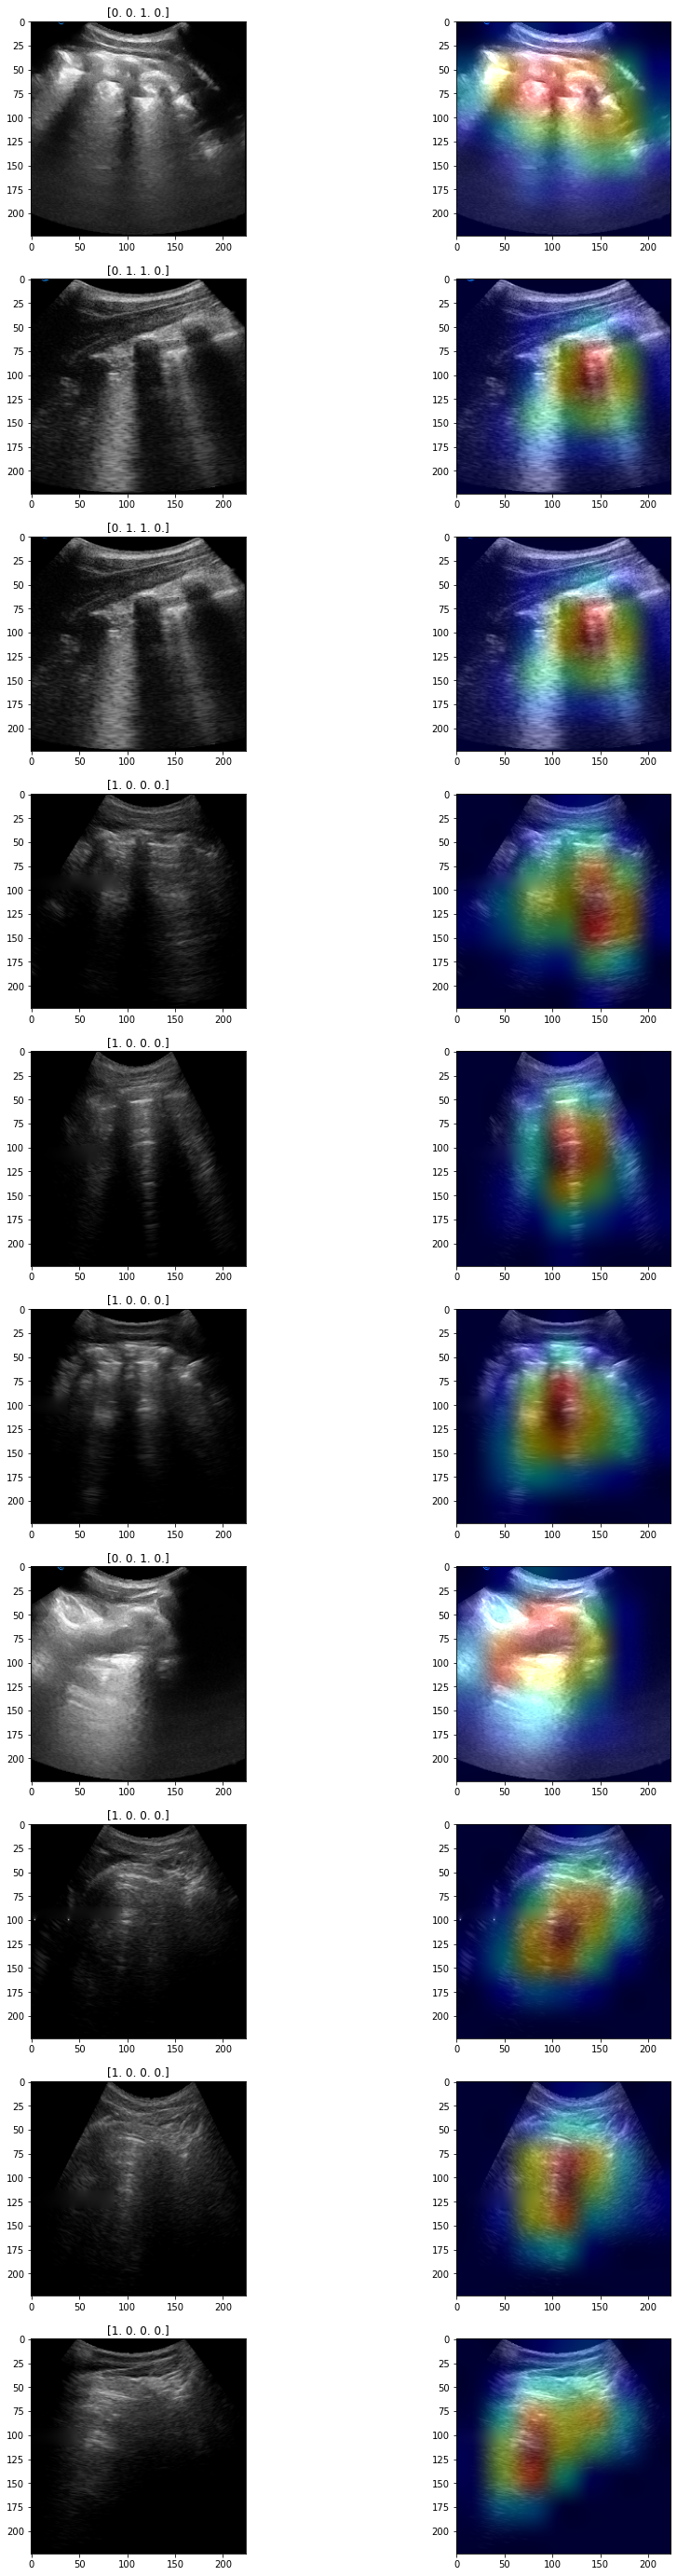

In [225]:
display_results(true_preds)